In [296]:
# Symbolic Formulation
import numpy as np
import sympy as sp
import time
import matplotlib.pyplot as plt

E = sp.symbols('E')
U = sp.symbols('U')
t = sp.symbols('t')

# n = number of atoms per ring
n = 17
# alpha matrix is interactions within rings
alpha = E*sp.eye(n)-U*sp.eye(n)
# tau matrix is interactions between rings
tau = t*sp.I*sp.eye(n)

iterations=2
h_old = alpha
tau_old = tau
for i in range(iterations):
    h_new = h_old - tau_old*tau_old.T.conj()*h_old.inv()
    tau_new = tau_old*tau_old.T.conj()*h_old.inv()
    h_old = h_new
    tau_old = tau_new
h_new
g = h_new.inv()
g

AttributeError: 'MutableDenseMatrix' object has no attribute 'conj'

In [295]:
# 1D Atomic Chain

# n = number of atoms per ring
n = 1
# E energy mode
E = -1+1j*10**(-8)

# N_P = number of rings in probe
N_P = 1
# a_P = probe interaction self energy
a_P = 0.5
# a_C = connection interaction energy
a_C = 0.4
H_P = a_P*(np.diag(2*np.ones(N_P))+np.diag(-np.ones(N_P-1),k=-1)+np.diag(-np.ones(N_P-1),k=1))
H_P_L = H_P
H_P_L[N_P-1,N_P-1] = a_P+a_C
H_P_R = H_P
H_P_R[0,0] = a_P+a_C

# N_D = number of rings in device
N_D = 2
# a_D = device interaction self energy
a_D = 0.6
H_D = a_D*(np.diag(2*np.ones(N_D))+np.diag(-np.ones(N_D-1),k=-1)+np.diag(-np.ones(N_D-1),k=1))
H_D[0,0] = a_D+a_C
H_D[N_D-1,N_D-1] = a_D+a_C

Tau_L=np.zeros((N_P,N_D))
Tau_L[N_P-1,0]=-a_C
Tau_R=np.zeros((N_P,N_D))
Tau_R[0,N_D-1]=-a_C

# Total Hamiltonian
H_tot = np.block([[H_P_L,Tau_L,np.zeros((N_P,N_P))],[Tau_L.T.conj(),H_D,Tau_R.T.conj()],[np.zeros((N_P,N_P)),Tau_R,H_P_R]])
matprint(H_tot)


# Computing Surface Green's Functions
start_time = time.time()
Sigma_L = np.matmul(np.matmul(Tau_L.T.conj(),np.linalg.inv(E*np.identity(N_P)-H_P_L)),Tau_L)
end_time = time.time()

print(Sigma_L[0,0],end_time-start_time)

# Decimation Method
iterations=5
h_s_old = E-(a_P+a_C)
h_b_old = E-2*a_C
tau_old = a_P

start_time = time.time()
for i in range(iterations):
    h_s_new = h_s_old-tau_old**2/h_b_old
    h_b_new = h_b_old-2*tau_old**2/h_b_old
    tau_new = -tau_old**2/h_b_old
    h_s_old=h_s_new
    h_b_old=h_b_new
    tau_old=tau_new
end_time = time.time()

Sigma_L = np.zeros((N_D,N_D),dtype=np.complex128)
Sigma_L[0,0] = a_C**2*1/h_s_new

Sigma_R = np.zeros((N_D,N_D),dtype=np.complex128)
Sigma_R[N_D-1,N_D-1] = a_C**2*1/h_s_new

print(Sigma_L[0,0],end_time-start_time)


 0.9  -0.4     0     0  
-0.4     1  -0.6     0  
   0  -0.6     1  -0.4  
   0     0  -0.4   0.9  
(-0.08421052631578947-4.4321329639889193e-10j) 0.0001888275146484375
(-0.09151582641644064-5.764915847753829e-10j) 8.535385131835938e-05


In [251]:
# Calculating Current
G_D = np.linalg.inv(E*np.identity(N_D)- H_D - Sigma_L - Sigma_R)
Gamma_L = (Sigma_L-Sigma_L.T.conj())*1j
Gamma_R = (Sigma_R-Sigma_R.T.conj())*1j

I=np.matrix.trace(np.matmul(np.matmul(np.matmul(G_D.T.conj(),Gamma_L),G_D),Gamma_R))
print(I)

0j


In [179]:
# 3D recreation

# n = number of atoms per ring
n=1

# a_C = connection energy
a_C=0.3
# Connection Matrix
H_C = a_C*np.diag(np.ones(n))

# a_P = probe ineraction energy
a_P = 0.4
# H_P_C1 connection to 2 atoms probe
H_P_C1 = -a_P/2*(np.diag(np.ones(n)))
# H_P_C2 connection to 1 atoms probe
H_P_C2 = -a_P/2*(np.diag(np.ones(n)))

# H_P_a atom self energy probe
H_P_a = a_P*(np.diag(np.ones(n)))

# N_P = number of rings in probe
N_P=60

H_P=np.zeros((n*N_P,n*N_P))
for i in range(N_P):
    H_P[i*n:(i+1)*n,i*n:(i+1)*n]=H_P_a
    if i < N_P-1:
        if i % 4 == 0:
            H_P[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=H_P_C1.T.conj()
        if (i+2) % 4 == 0:
            H_P[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=H_P_C1
        if (i+1) % 2 == 0:
            H_P[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=H_P_C2
    if i < N_P-1:
        if i % 4 == 0:
            H_P[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=H_P_C1
        if (i+2) % 4 == 0:
            H_P[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=H_P_C1.T.conj()
        if (i+1) % 2 == 0:
            H_P[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=H_P_C2            

# a_D = device ineraction energy
a_D = 0.7
# H_D_C1 connection to 2 atoms device
H_D_C1 = -a_D/4*((np.diag(np.ones(n))+np.diag(np.ones(n-1),k=-1)))
H_D_C1[0,n-1] = -a_D/4
# H_D_C2 connection to 1 atoms device
H_D_C2 = -a_D/2*(np.diag(np.ones(n)))

# H_D_a atom self energy device
H_D_a = a_D*(np.diag(np.ones(n)))

# N_D = number of rings in device
N_D=2

H_D=np.zeros((n*N_D,n*N_D))
for i in range(N_D):
    H_D[i*n:(i+1)*n,i*n:(i+1)*n]=H_D_a
    if i < N_D-1:
        if (i % 4) % 4 == 0:
            H_D[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=H_D_C1.T.conj()
        if (i+2) % 4 == 0:
            H_D[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=H_D_C1
        if (i+1) % 2 == 0:
            H_D[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=H_D_C2
    if i < N_D-1:
        if i % 4 == 0:
            H_D[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=H_D_C1
        if (i+2) % 4 == 0:
            H_D[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=H_D_C1.T.conj()
        if (i+1) % 2 == 0:
            H_D[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=H_D_C2            

# Total Hamiltonian
H_tot = np.block([[H_P,np.zeros((n*N_P,n*N_D)),np.zeros((n*N_P,n*N_P))],[np.zeros((n*N_D,n*N_P)),H_D,np.zeros((n*N_D,n*N_P))],[np.zeros((n*N_P,n*N_P)),np.zeros((n*N_P,n*N_D)),H_P]])
# Add connection terms
H_tot[n*(N_P-1):n*N_P,n*N_P:n*(N_P+1)]=H_C
H_tot[n*N_P:n*(N_P+1),n*(N_P-1):n*N_P]=H_C.T.conj()
H_tot[n*(N_P+N_D-1):n*(N_P+N_D),n*(N_P+N_D):n*(N_P+N_D+1)]=H_C.T.conj()
H_tot[n*(N_P+N_D):n*(N_P+N_D+1),n*(N_P+N_D-1):n*(N_P+N_D)]=H_C

# Mode Space Approximation
V = np.zeros((n*(2*N_P+N_D),n*(2*N_P+N_D)),dtype=np.complex128)
for i in range(2*N_D+N_P):
    V[i*n:(i+1)*n,i*n:(i+1)*n]=np.linalg.eig(H_D_C1).eigenvectors

H_mode=np.matmul(V.T.conj(),np.matmul(H_tot,V))

H_P_mode = H_mode[0:(n*N_P),0:(n*N_P)]

# Computing Surface Green's Functions
start_time = time.time()
surface_g = np.linalg.inv(E*(1+(1j/10))*np.identity(N_P*n)-H_P_mode)
end_time = time.time()

matprint(surface_g[0:n,0:n])
print(end_time-start_time)
print('________________________________')

# Decimation Method
iterations=8
start_time = time.time()

h_0 = E*(1+(1j/10))*np.identity(n)-H_P_mode[0:n,0:n]
tau_0 = H_P_mode[n:2*n,0:n]
h_1 = h_0-np.matmul(np.matmul(tau_0,np.linalg.inv(h_0)),tau_0.T.conj())
h_star_1 = h_0-np.matmul(np.matmul(tau_0,np.linalg.inv(h_0)),tau_0.T.conj())- np.matmul(np.matmul(tau_0.T.conj(),np.linalg.inv(h_0)),tau_0)
tau_1 = np.matmul(np.matmul(tau_0,np.linalg.inv(h_0)),tau_0)
tau_star_1 = np.matmul(np.matmul(tau_0.T.conj(),np.linalg.inv(h_0)),tau_0.T.conj())
h_old = h_1
h_star_old = h_star_1
tau_old = tau_1
tau_star_old = tau_star_1
for i in range(iterations-1):
    h_new = h_old-np.matmul(np.matmul(tau_old,np.linalg.inv(h_star_old)),tau_star_old)
    h_star_new = h_star_old-np.matmul(np.matmul(tau_old,np.linalg.inv(h_star_old)),tau_star_old)--np.matmul(np.matmul(tau_star_old,np.linalg.inv(h_star_old)),tau_old)
    tau_new = np.matmul(np.matmul(tau_old,np.linalg.inv(h_star_old)),tau_old)
    tau_star_new = np.matmul(np.matmul(tau_star_old.T.conj(),np.linalg.inv(h_star_old)),tau_star_old.T.conj())
    h_old = h_new
    h_star_old = h_star_new
    tau_old = tau_new
    tau_star_old = tau_star_new
end_time = time.time()

matprint(np.linalg.inv(h_new))
print(end_time-start_time)


1.09004-4.25903j  
0.0018341541290283203
________________________________
-1.18245-4.72365j  
0.001990079879760742


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


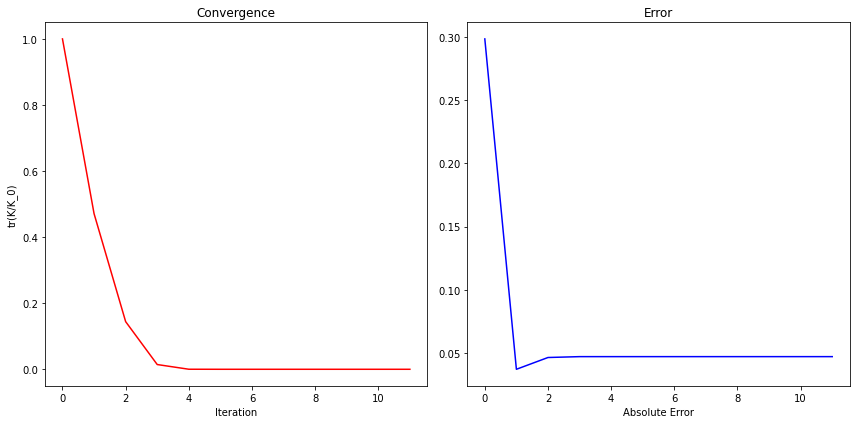

Time direct computation: 29.73079562187195s
Time decimation computation: 0.013120412826538086s


In [297]:
# Set up random matrices
n = 20
alpha_N1 = 1/np.sqrt(2)*(np.random.random((n,n)))
alpha_N2 = 1/np.sqrt(2)*(np.random.random((n,n))+1j*np.random.random((n,n)))
tau_N1 = 1/np.sqrt(2)*(np.random.random((n,n)))
tau_N2 = 1/np.sqrt(2)*(np.random.random((n,n))+1j*np.random.random((n,n)))

N = 400
H = np.zeros((N*n,N*n),dtype=np.complex128)
E = 10
for i in range(N):
    if i == 0:
        H[i*n:(i+1)*n,i*n:(i+1)*n]=E*np.diag(np.ones(n))-alpha_N1
        H[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=-tau_N1
        H[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=-tau_N1.T.conj()
    elif i == 1:
        H[i*n:(i+1)*n,i*n:(i+1)*n]=E*np.diag(np.ones(n))-alpha_N2
        H[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=-tau_N2
        H[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=-tau_N2.T.conj()
    else:
        #H[i*n:(i+1)*n,i*n:(i+1)*n]=E*np.diag(np.ones(n))-alpha_N2
        H[i*n:(i+1)*n,i*n:(i+1)*n]=E*np.diag(np.ones(n))-(np.random.random((n,n))+1j*np.random.random((n,n)))
        if i < N-1:
            #[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=-tau_N2
            #[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=-tau_N2.T.conj()            
            tau_i = np.random.random((n,n))+1j*np.random.random((n,n))
            H[i*n:(i+1)*n,(i+1)*n:(i+2)*n]=-tau_i
            H[(i+1)*n:(i+2)*n,i*n:(i+1)*n]=-tau_i.T.conj()

# Direct inverse
start_time = time.time()
g_direct = np.linalg.inv(H)
end_time = time.time()
time_direct = end_time-start_time

# Decimation Technique
start_time = time.time()

iterations=12

mu_0 = E*np.diag(np.ones(n))-alpha_N1
nu_0 = E*np.diag(np.ones(n))-alpha_N2
gamma_0 = tau_N1
zeta_0 = tau_N2
mu_old = mu_0-np.matmul(np.matmul(gamma_0,np.linalg.inv(nu_0)),gamma_0.T.conj())
nu_old = nu_0-np.matmul(np.matmul(zeta_0,np.linalg.inv(nu_0)),gamma_0.T.conj())- np.matmul(np.matmul(gamma_0.T.conj(),np.linalg.inv(nu_0)),zeta_0)
kappa_1 = np.matmul(np.matmul(gamma_0,np.linalg.inv(nu_0)),zeta_0)
kappa_old = kappa_1
gamma_old = np.matmul(np.matmul(gamma_0.T.conj(),np.linalg.inv(nu_0)),gamma_0.T.conj())
zeta_old = np.matmul(np.matmul(zeta_0,np.linalg.inv(nu_0)),zeta_0)

kappalist=np.zeros((iterations,1),dtype=np.complex128)
kappalist[0]=abs(np.trace(kappa_old/kappa_1*1/n))
errorlist=np.zeros((iterations,1),dtype=np.complex128)
errorlist[0]=abs(np.trace(np.linalg.inv(mu_0)-g_direct[0:n,0:n]))
for i in range(iterations-1):
    mu_new = mu_old - np.matmul(np.matmul(kappa_old,np.linalg.inv(nu_old)),gamma_old)
    nu_new = nu_old-np.matmul(np.matmul(zeta_old,np.linalg.inv(nu_old)),gamma_old)- np.matmul(np.matmul(gamma_old,np.linalg.inv(nu_old)),zeta_old)
    kappa_new = np.matmul(np.matmul(kappa_old,np.linalg.inv(nu_old)),zeta_old)
    gamma_new = np.matmul(np.matmul(gamma_old,np.linalg.inv(nu_old)),gamma_old)
    zeta_new = np.matmul(np.matmul(zeta_old,np.linalg.inv(nu_old)),zeta_old)

    
    mu_old = mu_new
    nu_old = nu_new
    kappa_old = kappa_new
    gamma_old = gamma_new
    zeta_old = zeta_new
    kappalist[i+1] = abs(np.trace(kappa_old/kappa_1*1/n))
    errorlist[i+1] = abs(np.trace(np.linalg.inv(mu_new)-g_direct[0:n,0:n]))
    
end_time = time.time()

time_decimation = end_time-start_time


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(kappalist, color='red')
ax1.set_title('Convergence')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('tr(K/K_0)')

ax2.plot(errorlist, color='blue')
ax2.set_title('Error')
ax2.set_xlabel('Absolute Error')
ax2.set_ylabel('')

plt.tight_layout()

plt.show()

print(f"Time direct computation: {time_direct}s")
print(f"Time decimation computation: {time_decimation}s")


In [ ]:
prittime_direct